In [1]:
import numpy as np
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points
import cv2
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import importlib.util
import sys
import traceback
import heapq
import time
from numba import njit, prange, guvectorize
from concurrent.futures import ThreadPoolExecutor

# Set up the dataset
nusc = NuScenes(version='v1.0-mini', dataroot='/home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes', verbose=True)

# Define the module name and file path
module_name = 'NuScenesExplorer'
file_path = '/home/nuno120/Documents/SCRIPTIE/scri/lib/python3.10/site-packages/nuscenes/nuscenes.py'


try:
    # Load the module specification from the file location
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    if spec is None:
        raise ImportError(f"Cannot find module '{module_name}' at '{file_path}'")

    # Create a new module based on the specification
    NuScExpl = importlib.util.module_from_spec(spec)

    # Execute the module in its own namespace
    spec.loader.exec_module(NuScExpl)

    # Optionally, add the module to sys.modules
    sys.modules[module_name] = NuScExpl

    # Now you can use the imported module
    print(f"Module '{module_name}' loaded successfully from '{file_path}'")
except Exception as e:
    print(f"Error importing module '{module_name}' from '{file_path}': {e}")
    traceback.print_exc()

# Load the sample
sample = nusc.sample[0]

# Get the camera data
camera_token_front = sample['data']['CAM_FRONT']
camera_token_front_right = sample['data']['CAM_FRONT_RIGHT']
camera_token_back_right = sample['data']['CAM_BACK_RIGHT']

camera_data_front = nusc.get('sample_data', camera_token_front)
camera_data_front_right = nusc.get('sample_data', camera_token_front_right)
camera_data_back_right = nusc.get('sample_data', camera_token_back_right)

lidar_token = sample['data']['LIDAR_TOP']


def debug_image(image):
    print("Debugging image:")
    print(f"Type: {type(image)}")
    print(f"Shape: {image.shape if isinstance(image, np.ndarray) else 'N/A'}")
    print(f"Dtype: {image.dtype if isinstance(image, np.ndarray) else 'N/A'}")
    print(f"Contains NaNs: {np.isnan(image).any() if isinstance(image, np.ndarray) else 'N/A'}")
    print(f"Contains Infinities: {np.isinf(image).any() if isinstance(image, np.ndarray) else 'N/A'}")
    if isinstance(image, np.ndarray) and image.ndim == 3 and image.shape[2] == 3:
        print(f"Min value: {image.min()}")
        print(f"Max value: {image.max()}")
    print("End of debug information")
    

def visualize_image(image, title="Image"):
    #check for image type 
    if not isinstance(image, np.ndarray):
        raise TypeError("Image should be a numpy array")
    print('vised image shape', image.shape)

    if image.ndim == 2:
        # Grayscale image
        if image.dtype != 'float32' and image.dtype != 'float64':
            image = image.astype('float32')
    elif image.ndim == 3 and image.shape[2] == 3:
        # RGB image
        if image.dtype != 'uint8':
            image = (image * 255).astype('uint8')  # Scale to [0, 255] and convert to uint8
    else:
        raise ValueError("Image must be either a 2D grayscale or 3D RGB array")
    image = np.nan_to_num(image, nan=0.0, posinf=255, neginf=0)

    #restart plt
    plt.close()
    plt.figure(figsize=(10, 5))
    plt.title(title)
    try:
        plt.imshow(image)
        #print('no error debug')
        #debug_image(image)
    except Exception as e:
        return
        #print(f"Error: {e}")
        #debug_image(image)
        
    
    plt.axis('off')
    plt.show()
    

def visualize_points(points, image, title="Points Overlay"):
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(image)
    plt.scatter(points[0, :], points[1, :], s=1, c='red')
    plt.axis('off')
    plt.show()


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.489 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Module 'NuScenesExplorer' loaded successfully from '/home/nuno120/Documents/SCRIPTIE/scri/lib/python3.10/site-packages/nuscenes/nuscenes.py'


In [2]:

def get_transformation_matrix(translation, rotation):
    q = Quaternion(rotation)
    transform_matrix = np.eye(4)
    transform_matrix[:3, :3] = q.rotation_matrix
    transform_matrix[:3, 3] = translation
    return transform_matrix


def convert_to_spherical(image, intrinsic):
    beginconvert = time.time()
    h, w = image.shape[:2]
    spherical_image = np.zeros_like(image)

    f = intrinsic[0, 0]
    u0 = intrinsic[0, 2]
    v0 = intrinsic[1, 2]

    # Vectorized coordinate transformations
    xp = (np.arange(w) - u0) / f
    yp = (np.arange(h)[:, np.newaxis] - v0) / f
    zp = np.ones_like(xp)

    xs = zp
    ys = -xp
    zs = -yp

    phi = np.arctan2(ys, xs)
    theta = np.arccos(zs / np.sqrt(xs**2 + ys**2 + zs**2))

    us = (u0 - f * phi).astype(int)
    vs = np.clip((v0 + f * (theta - np.pi / 2)).astype(int), 0, 900-1)

    # Assign pixels from original image to spherical image
    spherical_image[vs, us] = image

    endconvert = time.time()
    #print('convert2spherical time', endconvert-beginconvert)
    return spherical_image


def convert_lidar_to_spherical(lidar_points, intrinsic_matrix):
    """
    Converts Lidar points (x, y) to spherical coordinates.
    
    Parameters:
    - lidar_points: Numpy array of shape (N, 3) where each row is (x, y, z) for Lidar points.
    - intrinsic_matrix: 3x3 intrinsic camera matrix A
    
    Returns:
    - spherical_points: Numpy array of shape (N, 3) where each row is (phi, theta, z) in spherical coordinates.
    """
    beginlidar = time.time()   
    f = intrinsic_matrix[0, 0]
    u0 = intrinsic_matrix[0, 2]
    v0 = intrinsic_matrix[1, 2]

    # Extract x, y, z coordinates from lidar_points
    x_pinhole = lidar_points[:, 0] - u0
    y_pinhole = lidar_points[:, 1] - v0
    z_pinhole = f * np.ones_like(x_pinhole)

    # Convert to spherical coordinates
    x_spherical = z_pinhole
    y_spherical = -x_pinhole
    z_spherical = -y_pinhole

    phi = np.arctan2(y_spherical, x_spherical)
    theta = np.arccos(z_spherical / np.sqrt(x_spherical**2 + y_spherical**2 + z_spherical**2))

    # Convert back to image coordinates
    u_spherical = u0 - f * phi
    v_spherical = v0 + f * (theta - np.pi / 2)

    # Create spherical_points_new array to hold phi, theta, z
    spherical_points_new = np.zeros_like(lidar_points)
    spherical_points_new[:, 0] = u_spherical
    spherical_points_new[:, 1] = v_spherical
    spherical_points_new[:, 2] = lidar_points[:, 2]  # Keep the original z value

    endlidar = time.time()
    #print('lidar2spherical time', endlidar-beginlidar)
    return spherical_points_new

def estimate_overlapping_area(camera_matrix1, camera_matrix2, extrinsic_matrix1, extrinsic_matrix2, fov):
    relative_rotation = extrinsic_matrix2[:3, :3] @ np.linalg.inv(extrinsic_matrix1[:3, :3])
    relative_translation = extrinsic_matrix2[:3, 3] - extrinsic_matrix1[:3, 3]
    fov_rad = np.deg2rad(fov)
    overlap_horizontal = fov_rad - np.arccos(relative_rotation[0, 0])
    overlap_vertical = fov_rad - np.arccos(relative_rotation[1, 1])
    return overlap_horizontal, overlap_vertical

def align_images_with_lidar(image1, image2, lidar_points1, lidar_points2):
    print("in laign images with lidar points1 shape", lidar_points1[:, :2].shape)
    print("in laign images with lidar points2 shape", lidar_points2[:, :2])
    homography_matrix, _ = cv2.findHomography(lidar_points1[:, :2], lidar_points2[:, :2], method=cv2.RANSAC)
    h, w = image2.shape[:2]
    aligned_image1 = cv2.warpPerspective(image1, homography_matrix, (w, h))
    aligned_image2 = cv2.warpPerspective(image2, np.linalg.inv(homography_matrix), (w, h))
    return aligned_image1, aligned_image2

def get_homographies(lidar_points):
    homographies = []
    
    homography_matrix, _ = cv2.findHomography(lidar_points[0][:, :2], lidar_points[1][:, :2], method=cv2.RANSAC)
    homographies.append(homography_matrix)
    return homographies


def apply_homography(H, image):
    height, width = image.shape[:2]
    corners = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners, H)
    return transformed_corners

def create_stitched_image(images, homographies):
    transforms = [np.eye(3)]
    for H in homographies:
        transforms.append(H @ transforms[-1])

    all_corners = []
    for transform, image in zip(transforms, images):
        corners = apply_homography(transform, image)
        all_corners.append(corners)

    all_corners = np.concatenate(all_corners, axis=0)
    min_x = np.min(all_corners[:, 0, 0])
    max_x = np.max(all_corners[:, 0, 0])
    min_y = np.min(all_corners[:, 0, 1])
    max_y = np.max(all_corners[:, 0, 1])

    canvas_width = int(np.ceil(max_x - min_x))
    canvas_height = int(np.ceil(max_y - min_y))

    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    overlapping_regions = []

    for i in range(len(images)):
        transform = transforms[i]
        offset_transform = np.eye(3)
        offset_transform[0, 2] = -min_x
        offset_transform[1, 2] = -min_y
        full_transform = offset_transform @ transform
        warped_image = cv2.warpPerspective(images[i], full_transform, (canvas_width, canvas_height))

        mask = (warped_image > 0).astype(np.uint8)
        canvas = cv2.bitwise_and(canvas, 255 - mask)
        canvas = cv2.bitwise_or(canvas, warped_image)

        if i > 0:
            overlapping_regions.append((prev_warped_image, warped_image))

        prev_warped_image = warped_image
    
    return canvas, transforms, overlapping_regions

def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def apply_gaussian_blur(image, kernel_size, sigmax):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigmax)

def extract_horizontal_edges(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    return cv2.convertScaleAbs(sobelx)

def create_cost_map(overlap1, overlap2):
    # Use vectorized operations for mask and absolute difference
    mask = (overlap1 == 0) | (overlap2 == 0)
    result = np.abs(overlap1.astype(np.int16) - overlap2.astype(np.int16))
    result[mask] = 255
    return result.astype(np.uint8)

def add_weights(cost_map):
    rows, cols = cost_map.shape
    # Use broadcasting to apply weights
    weights = np.linspace(1, 2, rows).reshape(-1, 1)
    weighted_cost_map = cost_map * weights
    return weighted_cost_map

def find_minimal_energy_path(energy_map):
    rows, cols = energy_map.shape
    min_cost = np.full((rows, cols), np.inf)
    prev_column = np.zeros((rows, cols), dtype=int)
    
    # Initialize the bottom row
    min_cost[-1, :] = energy_map[-1, :]
    
    # Directions for moving to the upper row
    directions = [(-1, 0), (-1, -1), (-1, 1)]
    
    pq = [(energy_map[-1, c], rows - 1, c) for c in range(cols)]
    heapq.heapify(pq)
     
    while pq:
        current_cost, r, c = heapq.heappop(pq)
        
        if current_cost > min_cost[r, c]:
            continue
        
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols:
                new_cost = current_cost + energy_map[nr, nc]
                if new_cost < min_cost[nr, nc]:
                    min_cost[nr, nc] = new_cost
                    prev_column[nr, nc] = c
                    heapq.heappush(pq, (new_cost, nr, nc))
    
    seam_end_col = np.argmin(min_cost[0])
    seam = [seam_end_col]
    for r in range(1, rows):
        seam.append(prev_column[r, seam[-1]])
    
    return seam[::-1]

def find_seam(cost_map):
    rows, cols = cost_map.shape
    seam_energy = np.zeros_like(cost_map, dtype=np.float64)
    seam_energy[0, :] = cost_map[0, :]

    for i in range(1, rows):
        left = np.roll(seam_energy[i - 1, :], 1)
        right = np.roll(seam_energy[i - 1, :], -1)
        seam_energy[i, :] = cost_map[i, :] + np.minimum(seam_energy[i - 1, :], np.minimum(left, right))

    seam = find_minimal_energy_path(seam_energy)
    return seam

def draw_seam(image1, image2, seam, color_seam=False):
    h, w = image1.shape[:2]
    stitched_image = np.zeros_like(image1)

    for row in range(h):
        col = seam[row]
        if col > 0:
            stitched_image[row, :col] = image1[row, :col]
        if col < w - 1:
            stitched_image[row, col:] = image2[row, col:]
        if col == 0:
            stitched_image[row, col:] = image2[row, col:]
        elif col == w - 1:
            stitched_image[row, :col] = image1[row, :col]
    
    if color_seam:
        for row in range(h):
            stitched_image[row, seam[row]] = [255, 0, 0]

    return stitched_image




def get_bounding_box(image):
    rows = np.any(image, axis=1)
    cols = np.any(image, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return xmin, ymin, xmax, ymax


explorer = NuScExpl.NuScenesExplorer(nusc)

def trim_black_borders(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary mask where non-black regions are white
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours of the non-black regions
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box of the largest contour
    if len(contours) == 0:
        return image

    x, y, w, h = cv2.boundingRect(contours[0])
    for cnt in contours:
        x_, y_, w_, h_ = cv2.boundingRect(cnt)
        x = min(x, x_)
        y = min(y, y_)
        w = max(w, w_)
        h = max(h, h_)

    # Crop the image using the bounding box coordinates
    trimmed_image = image[y:y+h, x:x+w]

    return trimmed_image, x,y,w,h 

"""
def stitch_two_images_together(image1_spherical,image2_spherical, lidar_points_spherical, intrinsic_matrix_right_image,lidar_points_spherical_extra, lidar_distances_extra, lidar_points_right_extra_extra):
    #start with converting the images
    #image1 = images[0]
    #image2 = images[1]
    #image1_spherical = convert_to_spherical(image1, intrinsic_matrices[0])
    #image2_spherical = convert_to_spherical(image2, intrinsic_matrices[1])
    #lidar_points_spherical = [convert_lidar_to_spherical(points, intrinsic) for points, intrinsic in zip(lidar_points, intrinsic_matrices)]
    #visualize_points(lidar_points_spherical[0].T, image1_spherical, title='Lidar points in spherical image 1')
    #visualize_points(lidar_points_spherical[1].T, image2_spherical, title='Lidar points in spherical image 2')
    homography_matrix, _ = cv2.findHomography(lidar_points_spherical[0][:, :2], lidar_points_spherical[1][:, :2], method=cv2.RANSAC)
    h1, w1 = image1_spherical.shape[:2]
    h2, w2 = image2_spherical.shape[:2]
    canvas_height = max(h1, h2) + 2000
    canvas_width = w1 + w2 + 2000
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    #print('canvas shape', canvas.shape)

    # Calculate the starting position
    # Ensure the starting position is non-negative
    start_y = (canvas_height - h1) // 2

    start_x = 0  # Adding some padding from the left

    # Ensure the starting position is non-negative
    start_y = max(start_y, 0)
    start_x = max(start_x, 0)
    #print('starty', start_y)

    # Place image1_spherical in the middle of the canvas
    canvas[start_y:start_y + h1, start_x:start_x + w1] = image1_spherical

    #visualize_image(canvas)
    # Warp the first image to the canvas using the homography matrix
    aligned_image1 = cv2.warpPerspective(image2_spherical, np.linalg.inv(homography_matrix), (canvas_width, canvas_height))
    
    #start_y = aligned_image1.shape[0]//2
    #print('startreal,', start_y)
    
    aligned_image1 = np.roll(aligned_image1, start_y, axis=0)
    #visualize_image(aligned_image1, title='alignedimag1e')




    # Visualize the aligned image
    #visualize_image(aligned_image1, title='Aligned Image 1')
    #visualize_image(canvas, title='Canvas')

    overlap1 = cv2.bitwise_and(canvas, aligned_image1) #now get the box of the overlapping region
    
    
    rows = np.any(overlap1, axis=1) #now find the maxy, miny, maxx, minx of the overlapping region that are not black
    cols = np.any(overlap1, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    
    #now get the overlapping region from the canvas and the aligned image seperate
    color2copy = canvas[ymin:ymax, xmin:xmax].copy()
    color1copy= aligned_image1[ymin:ymax, xmin:xmax].copy()
    original_size = color1copy.shape

    #convert to gray
    gray1 = cv2.cvtColor(color1copy, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(color2copy, cv2.COLOR_BGR2GRAY)


    #scale down the images
    scale_percent = 50
    overlap1_resized = resize_image(gray1, scale_percent)
    overlap2_resized = resize_image(gray2, scale_percent)

    color1copy = resize_image(color1copy, scale_percent)
    color2copy = resize_image(color2copy, scale_percent)

    kernel_size = 7
    sigma = 0.5

    #apply gaussian blur
    overlap1_blurred = apply_gaussian_blur(overlap1_resized, kernel_size, sigma)
    overlap2_blurred = apply_gaussian_blur(overlap2_resized, kernel_size, sigma)

    overlap1_edges = extract_horizontal_edges(overlap1_blurred) #extract edges
    overlap2_edges = extract_horizontal_edges(overlap2_blurred)

    cost_map = create_cost_map(overlap1_edges, overlap2_edges) #create cost map
    weighted_cost_map = add_weights(cost_map)

    seam = find_seam(weighted_cost_map) #find the seam
    seam = seam[::-1] #revert order
    seam[-1] = seam[-2] #make the last value of the  seam, the one before that


    #now add the canvas and the aligned image together using the seam, each pixelindex in the seam is the pixel from the bounding box
    seam_image = 
    (color2copy, color1copy, seam, color_seam=False)
    seam_image = cv2.resize(seam_image, (original_size[1], original_size[0]))
    # Blend the aligned image and the second image together
    final_stitched_image = np.maximum(canvas, aligned_image1)

    roi = final_stitched_image[ymin:ymax, xmin:xmax]
    # Create a mask of non-zero values from seam_image
    mask = (seam_image != 0)
    # Copy seam_image into roi where mask is True (non-zero values in seam_image)
    roi[mask] = seam_image[mask]
    # Assign the modified roi back to the corresponding part in final_stitched_image
    final_stitched_image[ymin:ymax, xmin:xmax] = roi

    #visualize_image(final_stitched_image, title='Final Stitched Image')

    lidar_points_right_extra_extra = convert_lidar_to_spherical(lidar_points_right_extra_extra, intrinsic_matrix_right_image)
    lidar_points_right_extra_extra_homogeneuous = np.hstack([lidar_points_right_extra_extra[:, :2], np.ones((lidar_points_right_extra_extra.shape[0], 1))])
    transformed_points_right_extra_extra_homogeneous = np.dot(np.linalg.inv(homography_matrix), lidar_points_right_extra_extra_homogeneuous.T).T
    transformed_points_right_extra_extra = transformed_points_right_extra_extra_homogeneous[:, :2] / transformed_points_right_extra_extra_homogeneous[:, 2][:, np.newaxis]
    lidar_points_right_extra_extra = np.hstack([transformed_points_right_extra_extra, np.ones((transformed_points_right_extra_extra.shape[0], 1))])

    #visualize_points(lidar_points_right_extra_extra.T, final_stitched_image, title='Transformed Lidar points extra extra in final stitched image')

    #now we have the final image with the seam, let's also convert the lidar points
    lidar_points_spherical_left = lidar_points_spherical_extra[0]
    #print('lidar points shape spherical directly from input', lidar_points_spherical_left)
    lidar_points_spherical_right = lidar_points_spherical_extra[1]
    lidar_distances_extra_left = lidar_distances_extra[0]
    lidar_distances_extra_right = lidar_distances_extra[1]


    #print('lidar points spherical extra', lidar_points_spherical_extra[0].shape)
    # Visualize LIDAR points on spherical images
    #visualize_points(lidar_points_spherical_right.T, image2_spherical, title='Lidar points in spherical image 2')
    #visualize_points(lidar_points_spherical_left.T, image1_spherical, title='Lidar points in spherical image 1')


    #now transform the lidar points using the homography matrix
    #lidar_points_homogeneous = np.hstack([lidar_points_spherical_right[:, :2], np.ones((lidar_points_spherical_right.shape[0], 1))])
    #transformed_points_homogeneous = np.dot(np.linalg.inv(homography_matrix), lidar_points_homogeneous.T).T
    #transformed_points = transformed_points_homogeneous[:, :2] / transformed_points_homogeneous[:, 2][:, np.newaxis]
   
    #also for the extra lidar points
    lidar_points_homogeneous_extra = np.hstack([lidar_points_spherical_right[:, :2], np.ones((lidar_points_spherical_right.shape[0], 1))])
    transformed_points_homogeneous_extra = np.dot(np.linalg.inv(homography_matrix), lidar_points_homogeneous_extra.T).T
    transformed_points_extra = transformed_points_homogeneous_extra[:, :2] / transformed_points_homogeneous_extra[:, 2][:, np.newaxis]
    #now add one's to the transformed points
    lidar_points_spherical_right= np.hstack([transformed_points_extra, np.ones((transformed_points_extra.shape[0], 1))])

    #visualize_points(lidar_points_spherical_right.T, aligned_image1, title='Transformed Lidar points extra in aligned image 1')
    #visualize_points(lidar_points_spherical_left.T, canvas, title="Transformed extra canvas")

    #print('transformed points extra', transformed_points_extra.shape)
    #print('lidar points spherical extra', lidar_points_spherical_extra[1].shape)
    #now transform the seam to the total canvas by adding the bounding box coordinates
    #seam coordinates is just a list per row the coordinate. If above/below the bounding box assume no lidar coordinates
    seam = np.array(seam)
    scale_factor = 100 / scale_percent
    # Resize seam to match the original bounding box height
    seam_resized = []
    for x in seam:
        seam_resized.append(x)
        seam_resized.append(x)

    # Ensure the length of the seam_resized matches the height of the original bounding box
    while len(seam_resized) < ymax - ymin + 1:
        seam_resized.append(seam_resized[-1])

    # Scale the x-coordinates and adjust with xmin
    seam_image_coordinates = [(int(x * scale_factor) + xmin, y + ymin) for y, x in enumerate(seam_resized)]
    
    #print('seam image coordinates', seam_image_coordinates)
    
    #now we have the seam,plot it
    #{figure = plt.figure(figsize=(30, 20))
    #plt.imshow(final_stitched_image)
    #for x, y in seam_image_coordinates:
    #    plt.scatter(x, y, s=1, c='red')
    #plt.axis('off')
    #plt.title('seamsssslikegoodseam??')
    #plt.show()}


    #
    #now for left and right lidar points, we can filter left only on the left side and right only on the right side of the seam
    left_lidar_points = []
    left_lidar_distances = []
    for i in range(len(lidar_points_spherical_left)):
        x_lidar, y_lidar, z = lidar_points_spherical_left[i]
        y_lidar += start_y 
        #subtract ystart from y
        
        #print('ldar x,y', int(x_lidar), int(y_lidar))
        #now for this height(y), check if the x is left or right of the seam
        seam_coord = np.where(np.array(seam_image_coordinates)[:,1] == int(y_lidar))
        #print('seamcoord iindex', seam_coord)
        #print('seam image coordinates', np.array(seam_image_coordinates)[seam_coord])
        if len(seam_coord) == 0:
            continue
        #prevent index 0 is out of bounds for axis 0 with size 0
        if len(seam_coord[0]) == 0:
            continue
        
        if int(x_lidar) < np.array(seam_image_coordinates)[seam_coord][0][0]:
            #plt.scatter(x_lidar,y_lidar,s=1, c="red")
            left_lidar_points.append([x_lidar, y_lidar, z])
            left_lidar_distances.append(lidar_distances_extra_left[i])
    
    #print
    #print('lidar after filter shape', np.array(left_lidar_points).shape)
    right_lidar_points = []
    right_lidar_distances = []
    for i in range(len(lidar_points_spherical_right)):
        x_lidar, y_lidar, z = lidar_points_spherical_right[i]
        y_lidar += start_y 
        seam_coord = np.where(np.array(seam_image_coordinates)[:,1] == int(y_lidar))
        if len(seam_coord) == 0:
            continue
        if len(seam_coord[0]) == 0:
            continue
        
        if int(x_lidar) > np.array(seam_image_coordinates)[seam_coord][0][0]:
            right_lidar_points.append([x_lidar, y_lidar, z])
            right_lidar_distances.append(lidar_distances_extra_right[i])
            #plt.scatter(x_lidar,y_lidar,s=1, c="blue")
    
    
    total_filtered_lidar = np.vstack([left_lidar_points, right_lidar_points])
    
    
    total_filtered_lidar_distances = np.hstack([left_lidar_distances, right_lidar_distances])
    #print('total filtered lidar', total_filtered_lidar.shape)
    #print('total filtered lidar distances', total_filtered_lidar_distances.shape)
    #visualize_points(total_filtered_lidar.T, final_stitched_image, title='Total filtered lidar')


    final_stitched_image,x,y,w,h = trim_black_borders(final_stitched_image)
    #visualize_image(final_stitched_image, title='Final Stitched Image Trimmed')

    #now transform the lidar points to the final stitched image
    #print('total filtered lidar shape', total_filtered_lidar.shape)
    for i in range(len(total_filtered_lidar)):
        if len(total_filtered_lidar[i])== 3:
            x_lidar, y_lidar, _ = total_filtered_lidar[i]
        else:
            x_lidar, y_lidar = total_filtered_lidar[i]
        total_filtered_lidar[i] = [x_lidar - x, y_lidar - y, 1]

    #now visualize the lidar points on the final stitched image
    #visualize_points(total_filtered_lidar.T, final_stitched_image, title='Total filtered lidar on final stitched image after trimming')

    for i in range(len(lidar_points_right_extra_extra)):
        x_lidar, y_lidar, _ = lidar_points_right_extra_extra[i]
        
        lidar_points_right_extra_extra[i] = [x_lidar - x, y_lidar - y + start_y, 1]

    #visualize_points(lidar_points_right_extra_extra.T, final_stitched_image, title='Lidar points right extra extra on final stitched image after trimming')

    #total_lidar = np.vstack([lidar_points_spherical_left, lidar_points_spherical_right])
    #visualize_points(total_lidar.T, final_stitched_image,title='total lidar')
    return final_stitched_image, total_filtered_lidar, total_filtered_lidar_distances, lidar_points_right_extra_extra """
from scipy.sparse import csr_matrix
"""def stitch_two_images_together(image1_spherical, image2_spherical, lidar_points_spherical, intrinsic_matrix_right_image, lidar_points_spherical_extra, lidar_distances_extra, lidar_points_right_extra_extra):
    start = time.time()


    begin_homographytime = time.time()
    # Compute homography matrix
    homography_matrix, _ = cv2.findHomography(lidar_points_spherical[0][:, :2], lidar_points_spherical[1][:, :2], method=cv2.RANSAC)
    
    end_homographytime = time.time()
    print('homography time', end_homographytime-begin_homographytime)
    # Initialize canvas
    # Initialize canvas
    # Initialize canvas
    h1, w1 = image1_spherical.shape[:2]
    h2, w2 = image2_spherical.shape[:2]


    
    canvas_height = max(h1, h2) + 5000
    canvas_width = w1 + w2 + 2000
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    # Place image1_spherical in the canvas
    start_y = (canvas_height - h1) // 2
    start_x = 0

    
    canvas[start_y:start_y + h1, start_x:start_x + w1] = image1_spherical

    begin_warpp = time.time()
    # Warp image2_spherical and place it in the canvas
    aligned_image1 = cv2.warpPerspective(image2_spherical, np.linalg.inv(homography_matrix), (canvas_width, canvas_height))

    visualize_image(aligned_image1, title='alignedimag1e')
    end_warpp = time.time()
    print('warp perspective time', end_warpp-begin_warpp)
    begin_time_roll = time.time()
    aligned_image1 = np.roll(aligned_image1, start_y, axis=0)
    end_time_roll = time.time()
    print('np.roll time', end_time_roll-begin_time_roll)

    # Calculate overlap region
    begin_logicalend = time.time()
    overlap_region = np.logical_and(canvas.astype(bool), aligned_image1.astype(bool))
    end_logicaland = time.time()
    print('logical and time', end_logicaland-begin_logicalend)


    begin_convert_gray = time.time()
    # Find bounding box of the overlapping region
    sparse_overlap = csr_matrix(overlap_region[:,:,0])  # Assuming overlap_region[:,:,0] is the relevant matrix
    y_coords, x_coords = sparse_overlap.nonzero()

    if len(y_coords) > 0:
        ymin, ymax = np.min(y_coords), np.max(y_coords)
        xmin, xmax = np.min(x_coords), np.max(x_coords)
    else:
        # Handle case where no overlapping region is found
        ymin, ymax, xmin, xmax = 0, 0, 0, 0
    end_convert_gray = time.time()
    print('findboundingboxoverlappingregion', end_convert_gray-begin_convert_gray)
        

    # Extract and preprocess the overlapping region
    color2copy = canvas[ymin:ymax, xmin:xmax].copy()
    color1copy = aligned_image1[ymin:ymax, xmin:xmax].copy()

    original_size = color1copy.shape

    begin_convert_gray = time.time()
    gray1 = cv2.cvtColor(color1copy, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(color2copy, cv2.COLOR_BGR2GRAY)
    end_convert_gray = time.time()
    print('convert2gray time', end_convert_gray-begin_convert_gray)
        

    scale_percent = 50
    kernel_size = 9
    sigma = 1

    end_beforethread = time.time()
    print('time begin before thread', end_beforethread-end_homographytime)
    print('')
    # Resize images and apply Gaussian blur and edge extraction in parallel
    with ThreadPoolExecutor(max_workers=16) as executor:
        future1 = executor.submit(resize_image, gray1, scale_percent)
        future2 = executor.submit(resize_image, gray2, scale_percent)
        future3 = executor.submit(resize_image, color1copy, scale_percent)
        future4 = executor.submit(resize_image, color2copy, scale_percent)
        
        overlap1_resized = future1.result()
        overlap2_resized = future2.result()
        color1copy = future3.result()
        color2copy = future4.result()

        future1 = executor.submit(apply_gaussian_blur, overlap1_resized, kernel_size, sigma)
        future2 = executor.submit(apply_gaussian_blur, overlap2_resized, kernel_size, sigma)
        
        overlap1_blurred = future1.result()
        overlap2_blurred = future2.result()

        future1 = executor.submit(extract_horizontal_edges, overlap1_blurred)
        future2 = executor.submit(extract_horizontal_edges, overlap2_blurred)
        
        overlap1_edges = future1.result()
        overlap2_edges = future2.result()
    
    begin_seam_thing = time.time()
    print('thread time', begin_seam_thing-end_beforethread)
    print('begin part time', begin_seam_thing-end_homographytime)
    start_time = time.time()

    cost_map = create_cost_map(overlap1_edges, overlap2_edges)
    print(f"Time to create cost map: {time.time() - start_time} seconds")

    start_time = time.time()
    weighted_cost_map = add_weights(cost_map)
    print(f"Time to add weights: {time.time() - start_time} seconds")

    start_time = time.time()
    seam = find_seam(weighted_cost_map)[::-1]
    seam[-1] = seam[-2]
    print(f"Time to find seam: {time.time() - start_time} seconds")

    start_time = time.time()
    seam_image = draw_seam(color2copy, color1copy, seam, color_seam=False)
    print(f"Time to draw seam: {time.time() - start_time} seconds")

    

    start_time = time.time()
    seam_image = cv2.resize(seam_image, (original_size[1], original_size[0]))
    print(f"Time to resize seam image: {time.time() - start_time} seconds")

    start_time = time.time()
    final_stitched_image = np.maximum(canvas, aligned_image1)
    print(f"Time to create final stitched image: {time.time() - start_time} seconds")

    start_time = time.time()
    roi = final_stitched_image[ymin:ymax, xmin:xmax]
    mask = (seam_image != 0)
    roi[mask] = seam_image[mask]
    final_stitched_image[ymin:ymax, xmin:xmax] = roi
    end_seam_thing = time.time()
    print('seam thing time', end_seam_thing - begin_seam_thing)


    begin_last_part = time.time()

    # Transform lidar points
    lidar_points_right_extra_extra = transform_lidar_points(lidar_points_right_extra_extra, intrinsic_matrix_right_image, homography_matrix)
    lidar_points_spherical_right = transform_lidar_points(lidar_points_spherical_extra[1], intrinsic_matrix_right_image, homography_matrix)

    # Filter lidar points based on the seam
    seam_image_coordinates = create_seam_image_coordinates(seam, ymin, ymax, xmin, scale_percent, scale_factor=100 / scale_percent)
    left_lidar_points, left_lidar_distances = filter_lidar_points(lidar_points_spherical_extra[0], lidar_distances_extra[0], seam_image_coordinates, start_y, side='left')
    right_lidar_points, right_lidar_distances = filter_lidar_points(lidar_points_spherical_right, lidar_distances_extra[1], seam_image_coordinates, start_y, side='right')

    total_filtered_lidar = np.vstack([left_lidar_points, right_lidar_points])
    total_filtered_lidar_distances = np.hstack([left_lidar_distances, right_lidar_distances])

    # Trim black borders from the final stitched image
    final_stitched_image, x, y, _, _ = trim_black_borders(final_stitched_image)
    total_filtered_lidar = update_lidar_points(total_filtered_lidar, x, y)
    lidar_points_right_extra_extra = update_lidar_points(lidar_points_right_extra_extra, x, y, start_y)

    end = time.time()
    #print('Processing time stitch2 images:', end - start)
    #print('processing last part time', end - begin_last_part)
    return final_stitched_image, total_filtered_lidar, total_filtered_lidar_distances, lidar_points_right_extra_extra
"""
def transform_lidar_points(lidar_points, intrinsic_matrix, homography_matrix):
    begintransformlidarpoints = time.time()
    lidar_points_spherical = convert_lidar_to_spherical(lidar_points, intrinsic_matrix)
    lidar_points_homogeneous = np.hstack([lidar_points_spherical[:, :2], np.ones((lidar_points_spherical.shape[0], 1))])
    transformed_points_homogeneous = np.dot(np.linalg.inv(homography_matrix), lidar_points_homogeneous.T).T
    transformed_points = transformed_points_homogeneous[:, :2] / transformed_points_homogeneous[:, 2][:, np.newaxis]
    output = np.hstack([transformed_points, np.ones((transformed_points.shape[0], 1))])
    endtransformlidarpoints = time.time()
    #print('transform lidar points time', endtransformlidarpoints - begintransformlidarpoints)
    return output

def create_seam_image_coordinates(seam, ymin, ymax, xmin, scale_percent, scale_factor):
    beginseam = time.time()
    seam_resized = [x for x in seam for _ in range(2)]
    while len(seam_resized) < ymax - ymin + 1:
        seam_resized.append(seam_resized[-1])
    
    output = [(int(x * scale_factor) + xmin, y + ymin) for y, x in enumerate(seam_resized)]
    endseam = time.time()
    #print('create seam image coordinates time', endseam - beginseam)
    return output

def filter_lidar_points(lidar_points, lidar_distances, seam_image_coordinates, start_y, side='left'):
    beginfilterlidar = time.time()

    # Convert seam_image_coordinates to a dictionary for fast lookup
    seam_dict = {y: x for x, y in seam_image_coordinates}

    # Adjust y-coordinates by adding start_y
    lidar_points[:, 1] += start_y

    # Create boolean mask for filtering
    mask = np.zeros(len(lidar_points), dtype=bool)

    # Use vectorized operations to determine the mask
    for i, (x_lidar, y_lidar, z) in enumerate(lidar_points):
        seam_x = seam_dict.get(int(y_lidar), None)
        if seam_x is not None:
            if (side == 'left' and x_lidar < seam_x) or (side == 'right' and x_lidar > seam_x):
                mask[i] = True

    # Filter points and distances using the mask
    filtered_points = lidar_points[mask]
    filtered_distances = lidar_distances[mask]

    endfilterlidar = time.time()
    #print('filter lidar time', endfilterlidar - beginfilterlidar)
    return filtered_points, filtered_distances

def update_lidar_points(lidar_points, x, y, start_y=0):
    beginupdatelidar = time.time()
    for i in range(len(lidar_points)):
        if len(lidar_points[i]) == 3:
            x_lidar, y_lidar, _ = lidar_points[i]
        else:
            x_lidar, y_lidar = lidar_points[i]
        lidar_points[i] = [x_lidar - x, y_lidar - y + start_y, 1]
    endupdatelidar = time.time()
    #print('update lidar time', endupdatelidar-beginupdatelidar)
    return lidar_points
import os

In [3]:
def get_camera_data(sample, camera_names, nusc, explorer, visualize_images=False):
    camera_tokens = [sample['data'][name] for name in camera_names]
    with ThreadPoolExecutor() as executor:
        camera_data = list(executor.map(lambda token: nusc.get('sample_data', token), camera_tokens))
        camera_calibrations = list(executor.map(lambda data: nusc.get('calibrated_sensor', data['calibrated_sensor_token']), camera_data))
        
    intrinsic_matrices = [np.array(calibration['camera_intrinsic']) for calibration in camera_calibrations]
    extrinsic_matrices = [get_transformation_matrix(calibration['translation'], calibration['rotation']) for calibration in camera_calibrations]
    
    """def load_image(data):
        image_path = os.path.join(nusc.dataroot, data['filename'])
        image = cv2.imread(image_path)
        if image is not None:
            visualize_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        return None
    
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(load_image, camera_data))
    """
    def map_lidar(camera_token):
        points, depth, im = explorer.map_pointcloud_to_image(sample['data']['LIDAR_TOP'], camera_token)
        return points, depth, im
    
    mapped_lidar = []
    distances = []
    images = []
    
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(map_lidar, camera_tokens))
    for points, depth,im in results:
        mapped_lidar.append(points)
        distances.append(depth)
        im = np.array(im)
        images.append(im)
        #print the image
        
        #print('imaeg shape', im.shape)
        #print('image type', type(im))
        #visualize_image(im, 'image')

        
    
    # Prepare lists to hold LiDAR points and corresponding colors
    lidar_points = []
    lidar_colors = []
    
    def get_corresponding_points(camera_token_pair):
        token1, token2 = camera_token_pair
        points1, color1, _, points2, color2, _ = explorer.get_corresponding_points(sample['data']['LIDAR_TOP'], token1, token2)
        return points1, color1, points2, color2
    
    camera_token_pairs = [(camera_tokens[i], camera_tokens[i + 1]) for i in range(len(camera_tokens) - 1)]
    
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(get_corresponding_points, camera_token_pairs))
    
    for points1, color1, points2, color2 in results:
        lidar_points.extend([points1, points2])
        lidar_colors.extend([color1, color2])
    
    # Render pointcloud in image (assuming it's needed for visualization purposes)
    if visualize_images:
        for camera_name in camera_names:
            nusc.render_pointcloud_in_image(sample['token'], pointsensor_channel='LIDAR_TOP', camera_channel=camera_name)
    
    return camera_data, intrinsic_matrices, extrinsic_matrices, images, lidar_points, lidar_colors, mapped_lidar, distances




Exception in thread Thread-575 (convert_and_assign):
Traceback (most recent call last):
  File "/home/nuno120/miniconda3/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/nuno120/Documents/SCRIPTIE/scri/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/nuno120/miniconda3/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_89304/187012476.py", line 321, in convert_and_assign
  File "/tmp/ipykernel_89304/1787054201.py", line 34, in convert_to_spherical
IndexError: index 89 is out of bounds for axis 1 with size 3
Exception in thread Thread-577 (convert_and_assign):
Traceback (most recent call last):
  File "/home/nuno120/miniconda3/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
Exception in thread Thread-576 (convert_and_assign):
Traceback (most recent call last):
  File "/home/nuno120/miniconda3/lib

Processing time for all tasks: 0.6377983093261719
vised image shape (2210, 5600, 3)


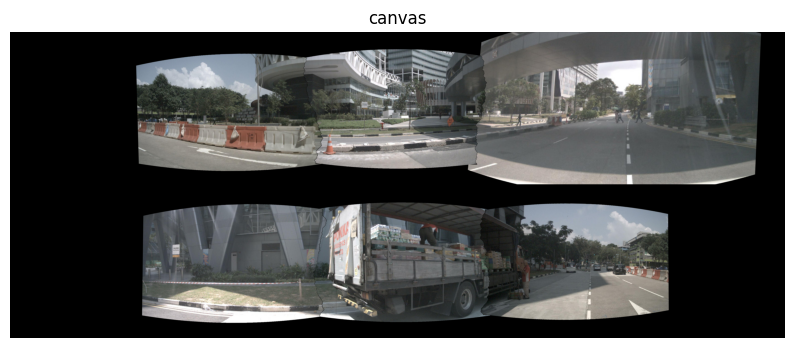

'#now run yolo\nimport cv2\n\n\n# Number of samples\nnum_samples = 30  # Since you want to include 0 to 100\n\n# List to store times\ntimes = []\n\n# Loop through each sample number\nfor i in range(num_samples):\n    start_time = time.time()\n    bigimageeee = get_data(i)\n    end_time = time.time()\n    elapsed_time = end_time - start_time\n    #visualize_image(bigimageeee, title=\'big image\')\n    times.append(elapsed_time)\n\n# Calculate average time\naverage_time = sum(times) / len(times)\nprint(f"Average time taken: {average_time:.6f} seconds")\nimport cProfile\nimport pstats\n\n# Run the profiling and capture the output\nprofiler = cProfile.Profile()\nprofiler.enable()\ncamera_indexes = [2,3,4]\n# Replace with your actual function call\nget_big_image2(sample_number, camera_indexes)\n\nprofiler.disable()\n\n# Sort by time (cumulative or internal, as needed)\nsort_by = \'cumulative\'  # or \'time\', \'calls\', etc.\nstats = pstats.Stats(profiler).sort_stats(sort_by)\n\n# Print the

In [5]:
def draw_seam(image1, image2, seam, color_seam=False):
    h, w = image1.shape[:2]
    stitched_image = np.zeros_like(image1)

    for row in range(h):
        col = seam[row]
        if col > 1:
            stitched_image[row, :col-1] = image1[row, :col-1]
        if col < w - 1:
            stitched_image[row, col:] = image2[row, col:]
        if col == 0:
            stitched_image[row, col:] = image2[row, col:]
        elif col == w - 1:
            stitched_image[row, :col-1] = image1[row, :col-1]
    
    if color_seam:
        for row in range(h):
            stitched_image[row, seam[row]] = [255, 0, 0]
    
    return stitched_image
def add_left_image(canvas, left_image, corresponding_lidar_points_canvas, corresponding_lidar_points_left):
    # Compute homography matrix
    homography_matrix, _ = cv2.findHomography(corresponding_lidar_points_canvas[:, :2], corresponding_lidar_points_left[:, :2], method=cv2.RANSAC)
    end_homographytime = time.time()
    # Warp left image and place it in the canvas
    aligned_image1 = cv2.warpPerspective(left_image, np.linalg.inv(homography_matrix), (canvas.shape[1], canvas.shape[0]))
    
    #visualize_image(aligned_image1, title='aligned image')

    begin_logicalend = time.time()
    overlap_region = (canvas > 0) & (aligned_image1 > 0)
    end_logicaland = time.time()
    #print('logical and time', end_logicaland-begin_logicalend)


    begin_convert_gray = time.time()
    # Find bounding box of the overlapping region
    # Find bounding box of the overlapping region
    sparse_overlap = csr_matrix((overlap_region[:,:,0]).astype(int))  # Assuming overlap_region[:,:,0] is the relevant matrix
    y_coords, x_coords = sparse_overlap.nonzero()

    if len(y_coords) > 0:
        ymin, ymax = np.min(y_coords), np.max(y_coords)
        xmin, xmax = np.min(x_coords), np.max(x_coords)
    else:
        # Handle case where no overlapping region is found
        ymin, ymax, xmin, xmax = 0, 0, 0, 0
    end_convert_gray = time.time()
    #print('findboundingboxoverlappingregion', end_convert_gray-begin_convert_gray)
        

    # Extract and preprocess the overlapping region
    color2copy = canvas[ymin:ymax, xmin:xmax].copy()
    color1copy = aligned_image1[ymin:ymax, xmin:xmax].copy()

    original_size = color1copy.shape

    begin_convert_gray = time.time()
    gray1 = cv2.cvtColor(color1copy, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(color2copy, cv2.COLOR_BGR2GRAY)
    end_convert_gray = time.time()
    #print('convert2gray time', end_convert_gray-begin_convert_gray)
        

    scale_percent = 50
    kernel_size = 9
    sigma = 1

    end_beforethread = time.time()
    #print('time begin before thread', end_beforethread-end_homographytime)
    #print('')
    # Resize images and apply Gaussian blur and edge extraction in parallel
    with ThreadPoolExecutor(max_workers=16) as executor:
        future1 = executor.submit(resize_image, gray1, scale_percent)
        future2 = executor.submit(resize_image, gray2, scale_percent)
        future3 = executor.submit(resize_image, color1copy, scale_percent)
        future4 = executor.submit(resize_image, color2copy, scale_percent)
        
        overlap1_resized = future1.result()
        overlap2_resized = future2.result()
        color1copy = future3.result()
        color2copy = future4.result()

        future1 = executor.submit(apply_gaussian_blur, overlap1_resized, kernel_size, sigma)
        future2 = executor.submit(apply_gaussian_blur, overlap2_resized, kernel_size, sigma)
        
        overlap1_blurred = future1.result()
        overlap2_blurred = future2.result()

        future1 = executor.submit(extract_horizontal_edges, overlap1_blurred)
        future2 = executor.submit(extract_horizontal_edges, overlap2_blurred)
        
        overlap1_edges = future1.result()
        overlap2_edges = future2.result()
    
    begin_seam_thing = time.time()
    #print('thread time', begin_seam_thing-end_beforethread)
    #print('begin part time', begin_seam_thing-end_homographytime)
    start_time = time.time()

    cost_map = create_cost_map(overlap1_edges, overlap2_edges)
    #print(f"Time to create cost map: {time.time() - start_time} seconds")

    start_time = time.time()
    weighted_cost_map = add_weights(cost_map)
    #print(f"Time to add weights: {time.time() - start_time} seconds")

    start_time = time.time()
    seam = find_seam(weighted_cost_map)[::-1]
    seam[-1] = seam[-2]
    #print(f"Time to find seam: {time.time() - start_time} seconds")

    start_time = time.time()

    black_canvas = np.zeros_like(color2copy)
    # Now add one to the seam
    seam_image = draw_seam(color1copy, black_canvas, seam, color_seam=False)
    #print('type seam image')
    #print(type(seam_image))
    #print(f"Time to draw seam: {time.time() - start_time} seconds")

    start_time = time.time()
    seam_image = cv2.resize(seam_image, (original_size[1], original_size[0]))
    #print(f"Time to resize seam image: {time.time() - start_time} seconds")

    #visualize_image(seam_image, title='seam image')

    start_time = time.time()

    # Overlay the seam_image on aligned_image1 using ROI and blending
    final_stitched_image = aligned_image1.copy()

    
    final_stitched_image[ymin:ymax, xmin:xmax] = seam_image

    #print(f"Time to create final stitched image: {time.time() - start_time} seconds")

    end_seam_thing = time.time()
    #print('seam thing time', end_seam_thing - begin_seam_thing)

    return final_stitched_image

def add_right_image(canvas, right_image, corresponding_lidar_points_canvas, corresponding_lidar_points_right):
    # Compute homography matrix
    homography_matrix, _ = cv2.findHomography(corresponding_lidar_points_canvas[:, :2], corresponding_lidar_points_right[:, :2], method=cv2.RANSAC)
    end_homographytime = time.time()
    # Warp right image and place it in the canvas
    aligned_image2 = cv2.warpPerspective(right_image, np.linalg.inv(homography_matrix), (canvas.shape[1], canvas.shape[0]))
    
    #visualize_image(aligned_image2, title='aligned image')

    begin_logicalend = time.time()
    overlap_region = (canvas > 0) & (aligned_image2 > 0)
    end_logicaland = time.time()
    #print('logical and time', end_logicaland - begin_logicalend)

    begin_convert_gray = time.time()
    # Find bounding box of the overlapping region
    # Find bounding box of the overlapping region
    sparse_overlap = csr_matrix((overlap_region[:,:,0]).astype(int))  # Assuming overlap_region[:,:,0] is the relevant matrix
    y_coords, x_coords = sparse_overlap.nonzero()

    if len(y_coords) > 0:
        ymin, ymax = np.min(y_coords), np.max(y_coords)
        xmin, xmax = np.min(x_coords), np.max(x_coords)
    else:
        # Handle case where no overlapping region is found
        ymin, ymax, xmin, xmax = 0, 0, 0, 0
    end_convert_gray = time.time()
    #print('findboundingboxoverlappingregion', end_convert_gray - begin_convert_gray)

    # Extract and preprocess the overlapping region
    color2copy = canvas[ymin:ymax, xmin:xmax].copy()
    color1copy = aligned_image2[ymin:ymax, xmin:xmax].copy()

    original_size = color1copy.shape

    begin_convert_gray = time.time()
    gray1 = cv2.cvtColor(color1copy, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(color2copy, cv2.COLOR_BGR2GRAY)
    end_convert_gray = time.time()
    #print('convert2gray time', end_convert_gray - begin_convert_gray)

    scale_percent = 50
    kernel_size = 9
    sigma = 1

    end_beforethread = time.time()
    #print('time begin before thread', end_beforethread - end_homographytime)
    #print('')
    # Resize images and apply Gaussian blur and edge extraction in parallel
    with ThreadPoolExecutor(max_workers=16) as executor:
        future1 = executor.submit(resize_image, gray1, scale_percent)
        future2 = executor.submit(resize_image, gray2, scale_percent)
        future3 = executor.submit(resize_image, color1copy, scale_percent)
        future4 = executor.submit(resize_image, color2copy, scale_percent)

        overlap1_resized = future1.result()
        overlap2_resized = future2.result()
        color1copy = future3.result()
        color2copy = future4.result()

        future1 = executor.submit(apply_gaussian_blur, overlap1_resized, kernel_size, sigma)
        future2 = executor.submit(apply_gaussian_blur, overlap2_resized, kernel_size, sigma)

        overlap1_blurred = future1.result()
        overlap2_blurred = future2.result()

        future1 = executor.submit(extract_horizontal_edges, overlap1_blurred)
        future2 = executor.submit(extract_horizontal_edges, overlap2_blurred)

        overlap1_edges = future1.result()
        overlap2_edges = future2.result()

    begin_seam_thing = time.time()
    #print('thread time RESIZEGAUSSEDGES', begin_seam_thing - end_beforethread)
    #print('begin part time', begin_seam_thing - end_homographytime)
    start_time = time.time()

    cost_map = create_cost_map(overlap1_edges, overlap2_edges)
    #print(f"Time to create cost map: {time.time() - start_time} seconds")

    start_time = time.time()
    weighted_cost_map = add_weights(cost_map)
    #print(f"Time to add weights: {time.time() - start_time} seconds")

    start_time = time.time()
    seam = find_seam(weighted_cost_map)[::-1]
    seam[-1] = seam[-2]
    #print(f"Time to find seam: {time.time() - start_time} seconds")

    start_time = time.time()

    black_canvas = np.zeros_like(color2copy)
    # Now add one to the seam
    seam_image = draw_seam(black_canvas,color1copy, seam, color_seam=False)
    #print(f"Time to draw seam: {time.time() - start_time} seconds")
    #visualize_image(seam_image, title='seam image')

    start_time = time.time()
    seam_image = cv2.resize(seam_image, (original_size[1], original_size[0]))
    #print(f"Time to resize seam image: {time.time() - start_time} seconds")

    #visualize_image(seam_image, title='seam image')

    start_time = time.time()

    # Overlay the seam_image on aligned_image2 using ROI and blending
    final_stitched_image = aligned_image2.copy()

    final_stitched_image[ymin:ymax, xmin:xmax] = seam_image

    #print(f"Time to create final stitched image: {time.time() - start_time} seconds")

    end_seam_thing = time.time()
    #print('seam thing time', end_seam_thing - begin_seam_thing)

    return final_stitched_image


import threading 

def transform_points(points, offset_x, offset_y):
    return np.array([[x + offset_x, y + offset_y, 1] for x, y, _ in points])
"""
def transform_points(points, offset):
    return np.array([[x + offset, y + offset, 1] for x, y, _ in points])
"""
def add_images_in_parallel(canvas, images_and_points):
    with ThreadPoolExecutor() as executor:
        futures = []
        for add_func, img, src_pts, dst_pts in images_and_points:
            futures.append(executor.submit(add_func, canvas, img, src_pts, dst_pts))
        results = [future.result() for future in futures]
    return results


def get_big_image2(sample_number, camera_indexes):
    camera_names = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_RIGHT', 'CAM_BACK', 'CAM_BACK_LEFT']
    selected_camera_names = [camera_names[i] for i in camera_indexes]
    sample = nusc.sample[sample_number]

    # Retrieve camera data
    camera_data, intrinsic_matrices, extrinsic_matrices, images, corresponding_lidar_points, _, total_lidar, total_lidar_distances = get_camera_data(sample, selected_camera_names, nusc, explorer)

    def process_images_and_data(images, total_lidar, intrinsic_matrices, corresponding_lidar_points):
        left_image, mid_image, right_image = images[:3]

        total_lidar = [lidar.T for lidar in total_lidar[:3]]

        intrinsic_left, intrinsic_mid, intrinsic_right = intrinsic_matrices[:3]

        corresponding_lidar_points_left_mid = corresponding_lidar_points[:2]
        corresponding_lidar_points_mid_right = corresponding_lidar_points[2:]

        return left_image, mid_image, right_image, total_lidar, intrinsic_left, intrinsic_mid, intrinsic_right, corresponding_lidar_points_left_mid, corresponding_lidar_points_mid_right
    
    with ThreadPoolExecutor() as executor:
        future = executor.submit(process_images_and_data, images, total_lidar, intrinsic_matrices, corresponding_lidar_points)
        result = future.result()

    # Unpack the result
    left_image, mid_image, right_image, total_lidar, intrinsic_left, intrinsic_mid, intrinsic_right, corresponding_lidar_points_left_mid, corresponding_lidar_points_mid_right = result
    """
    begin_convert_spherical = time.time()
    left_image_spherical = convert_to_spherical(left_image, intrinsic_left)
    mid_image_spherical = convert_to_spherical(mid_image, intrinsic_mid)
    right_image_spherical = convert_to_spherical(right_image, intrinsic_right)

    lidar_points_left_spherical = convert_lidar_to_spherical(corresponding_lidar_points_left_mid[0], intrinsic_left)
    lidar_points_midleft_spherical = convert_lidar_to_spherical(corresponding_lidar_points_left_mid[1], intrinsic_mid)
    lidar_points_midright_spherical = convert_lidar_to_spherical(corresponding_lidar_points_mid_right[0], intrinsic_mid)
    lidar_points_right_spherical = convert_lidar_to_spherical(corresponding_lidar_points_mid_right[1], intrinsic_right)
    total_lidar_spherical = [convert_lidar_to_spherical(points, intrinsic) for points, intrinsic in zip(total_lidar, intrinsic_matrices[:3])]
    end_convert_spherical = time.time()
    print('convert spherical time', end_convert_spherical - begin_convert_spherical)
    """
    begin_convert_spherical = time.time()

    def convert_and_assign(image, intrinsic, result_list):
        result_list.append(convert_to_spherical(image, intrinsic))
    
    def convert_and_assign_lidar(points, intrinsic, result_list):
        result_list.append(convert_lidar_to_spherical(points, intrinsic))

    left_image_spherical = []
    mid_image_spherical = []
    right_image_spherical = []

    lidar_points_left_spherical = []
    lidar_points_midleft_spherical = []
    lidar_points_midright_spherical = []
    lidar_points_right_spherical = []
    total_lidar_spherical = [[] for _ in range(3)]

    threads = []

    # Define threading targets for image conversion
    threads.append(threading.Thread(target=convert_and_assign, args=(left_image, intrinsic_left, left_image_spherical)))
    threads.append(threading.Thread(target=convert_and_assign, args=(mid_image, intrinsic_mid, mid_image_spherical)))
    threads.append(threading.Thread(target=convert_and_assign, args=(right_image, intrinsic_right, right_image_spherical)))

    # Define threading targets for lidar conversion
    threads.append(threading.Thread(target=convert_and_assign_lidar, args=(corresponding_lidar_points_left_mid[0], intrinsic_left, lidar_points_left_spherical)))
    threads.append(threading.Thread(target=convert_and_assign_lidar, args=(corresponding_lidar_points_left_mid[1], intrinsic_mid, lidar_points_midleft_spherical)))
    threads.append(threading.Thread(target=convert_and_assign_lidar, args=(corresponding_lidar_points_mid_right[0], intrinsic_mid, lidar_points_midright_spherical)))
    threads.append(threading.Thread(target=convert_and_assign_lidar, args=(corresponding_lidar_points_mid_right[1], intrinsic_right, lidar_points_right_spherical)))

    # Define threading targets for total lidar conversion
    for i in range(3):
        threads.append(threading.Thread(target=convert_and_assign, args=(total_lidar[i], intrinsic_matrices[i], total_lidar_spherical[i])))

    # Start all threads
    for thread in threads:
        thread.start()

    # Wait for all threads to complete
    for thread in threads:
        thread.join()
    mid_image_spherical = mid_image_spherical[0]
    left_image_spherical = left_image_spherical[0]
    right_image_spherical = right_image_spherical[0]
    lidar_points_left_spherical = lidar_points_left_spherical[0]
    lidar_points_midleft_spherical = lidar_points_midleft_spherical[0]
    lidar_points_midright_spherical = lidar_points_midright_spherical[0]
    lidar_points_right_spherical = lidar_points_right_spherical[0]
    total_lidar_spherical = total_lidar_spherical

    
    end_convert_spherical = time.time()

    begin_canvasbigger = time.time()
    """offset =500
    canvas = cv2.copyMakeBorder(mid_image_spherical.copy(), offset, offset, offset, offset, cv2.BORDER_CONSTANT, value=0)
    """
    
    offset_x = 2000  # Offset for x coordinate
    offset_y = 100 # Offset for y coordinate

    canvas = cv2.copyMakeBorder(mid_image_spherical.copy(), offset_y, offset_y, offset_x, offset_x, cv2.BORDER_CONSTANT, value=0)
    #visualize_image(canvas, title='canvas')

    lidar_points_midleft_spherical = transform_points(lidar_points_midleft_spherical, offset_x, offset_y)
    lidar_points_midright_spherical = transform_points(lidar_points_midright_spherical, offset_x, offset_y)
    total_lidar_spherical[1] = transform_points(total_lidar_spherical[1], offset_x, offset_y)

    


    end_canvasbigger = time.time()
    #print('canvas bigger time', end_canvasbigger - begin_canvasbigger)

    images_and_points = [
        (add_left_image, left_image_spherical, lidar_points_midleft_spherical, lidar_points_left_spherical),
        (add_right_image, right_image_spherical, lidar_points_midright_spherical, lidar_points_right_spherical)
    ]

    start = time.time()
    [canvas_left, canvas_right] = add_images_in_parallel(canvas, images_and_points)
    end = time.time()
    #print('Processing time for adding images:', end - start)
    #visualize_image(canvas_left, title='canvas left')
    #visualize_image(canvas_right, title='canvas right')
    start_time = time.time()
    #now lay the canvas left and right over the canvas for the points that are not zero in the left and right iamges
    mask_combined_right = (canvas_right > 0)
    mask_combined_left = (canvas_left > 0) & ~mask_combined_right

    # Update the canvas
    canvas[mask_combined_right] = canvas_right[mask_combined_right]
    canvas[mask_combined_left] = canvas_left[mask_combined_left]
    end_time = time.time()
    #print('maskss time', end_time - start_time)

    #visualize_image(canvas, title='canvas')



    


    

    #canvas, x, y, _, _ = trim_black_borders(canvas)

    return canvas



import concurrent.futures


import time
import gc

def get_data(sample_number):
    gc.collect()  # Garbage collection to clean up memory

    tasks = [
        (sample_number, [2, 3, 4]),
        (sample_number, [5, 0, 1])
    ]

    def process_task(sample_number, camera_indexes):
        return get_big_image2(sample_number, camera_indexes)

    start = time.time()

    # Multithreading



    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_task, sample_number, camera_indexes) for sample_number, camera_indexes in tasks]
        results = [future.result() for future in futures]
    #visiaulize the images
    #visualize_image(results[0], title='result 1')
    #visualize_image(results[1], title='result 2')
    gap = 10
    canvas_height = results[0].shape[0] + results[1].shape[0] + gap
    canvas_width = max(results[0].shape[1], results[1].shape[1])

    #now create the canvas
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    # Place the first image in the canvas at the top and in the middle
    start_y = 0
    start_x = (canvas_width - results[0].shape[1]) // 2
    canvas[start_y:start_y + results[0].shape[0], start_x:start_x + results[0].shape[1]] = results[0]

    # Place the second image in the canvas at the bottom and in the middle
    start_y = results[0].shape[0] + gap
    start_x = (canvas_width - results[1].shape[1]) // 2
    canvas[start_y:start_y + results[1].shape[0], start_x:start_x + results[1].shape[1]] = results[1]
    

    # Display or save the canvas
    #now trim away the black borders
    #canvas, x, y, _, _ = trim_black_borders(canvas)
    
    end = time.time()
    print('Processing time for all tasks:', end - start)
    visualize_image(canvas, title='canvas')
    return canvas
# Print results


sample_number = 2
result = get_data(sample_number)

"""#now run yolo
import cv2


# Number of samples
num_samples = 30  # Since you want to include 0 to 100

# List to store times
times = []

# Loop through each sample number
for i in range(num_samples):
    start_time = time.time()
    bigimageeee = get_data(i)
    end_time = time.time()
    elapsed_time = end_time - start_time
    #visualize_image(bigimageeee, title='big image')
    times.append(elapsed_time)

# Calculate average time
average_time = sum(times) / len(times)
print(f"Average time taken: {average_time:.6f} seconds")
import cProfile
import pstats

# Run the profiling and capture the output
profiler = cProfile.Profile()
profiler.enable()
camera_indexes = [2,3,4]
# Replace with your actual function call
get_big_image2(sample_number, camera_indexes)

profiler.disable()

# Sort by time (cumulative or internal, as needed)
sort_by = 'cumulative'  # or 'time', 'calls', etc.
stats = pstats.Stats(profiler).sort_stats(sort_by)

# Print the sorted profiling results
stats.print_stats()
"""

Exception in thread Thread-826 (convert_and_assign):
Traceback (most recent call last):
  File "/home/nuno120/miniconda3/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
Exception in thread Thread-828 (convert_and_assign):
Traceback (most recent call last):
  File "/home/nuno120/miniconda3/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
Exception in thread Thread-827 (convert_and_assign):
Traceback (most recent call last):
  File "/home/nuno120/miniconda3/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/nuno120/Documents/SCRIPTIE/scri/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    self.run()
  File "/home/nuno120/Documents/SCRIPTIE/scri/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    self.run()
  File "/home/nuno120/Documents/SCRIPTIE/scri/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  Fil

Processing time for all tasks: 0.8749051094055176
vised image shape (2210, 5600, 3)


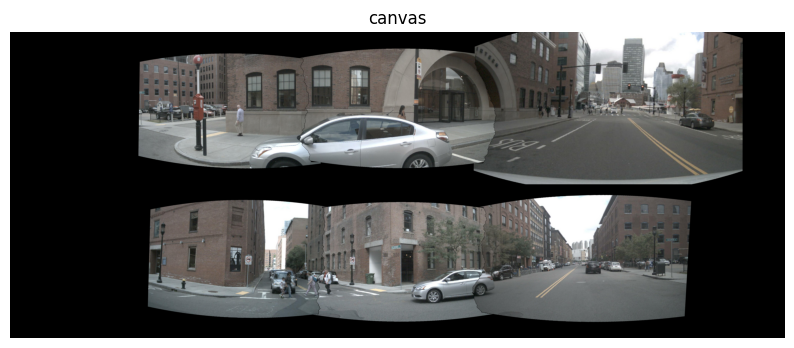

(2210, 5600, 3)
vised image shape (2210, 4368, 3)


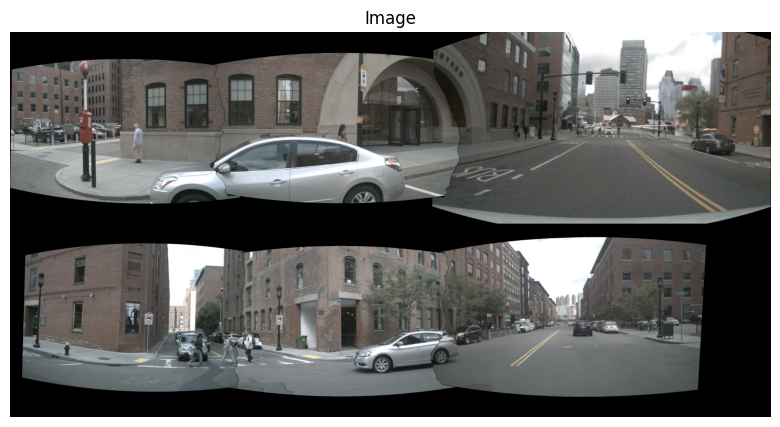

images/canvas.png


mkdir: cannot create directory ‘/home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results’: File exists


detect_dual: weights=['/home/nuno120/Downloads/results_DownlOAD/hva_exp13_imgs1200/epoch88.pt'], source=images/canvas.png, data=../yolov9/data/coco128.yaml, imgsz=[1216, 1216], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/nuno120/Documents/SCRIPTIE/yolov9/results, name=latest_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 2024-4-20 Python-3.10.0 torch-2.3.0+cu121 CPU

Fusing layers... 
yolov9-c summary: 604 layers, 50719068 parameters, 0 gradients, 236.7 GFLOPs
image 1/1 /home/nuno120/Documents/SCRIPTIE/real-time-image-stitching/images/canvas.png: 640x1216 1 bicycle, 14 cars, 7 pedestrians, 1251.8ms
Speed: 1.6ms pre-process, 1251.8ms inference, 0.8ms NMS per image at shape (1, 3, 1216, 1216)
Results saved to /home/nuno120/Documents/SCR

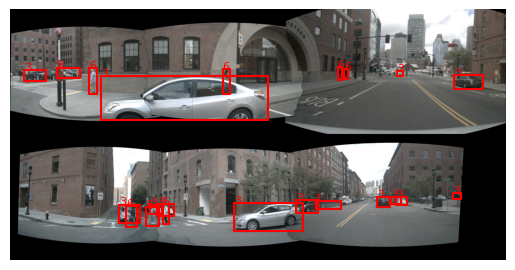

([3900.0,
  409.0,
  2944.0,
  1871.0,
  1344.0,
  3359.0,
  2884.0,
  1232.0,
  1021.0,
  2691.0,
  1195.0,
  3410.0,
  1292.0,
  958.0,
  2520.0,
  698.0,
  3399.0,
  126.0,
  3232.0,
  3908.0,
  800.0,
  1972.0],
 [1619.0,
  520.0,
  526.0,
  524.0,
  1719.0,
  1653.0,
  511.0,
  1726.0,
  1735.0,
  1688.0,
  1739.0,
  543.0,
  1719.0,
  1721.0,
  1680.0,
  520.0,
  1658.0,
  536.0,
  1652.0,
  580.0,
  590.0,
  1710.0],
 [3974.0,
  612.0,
  2980.0,
  1939.0,
  1399.0,
  3442.0,
  2925.0,
  1342.0,
  1120.0,
  2913.0,
  1310.0,
  3462.0,
  1447.0,
  1145.0,
  2710.0,
  764.0,
  3493.0,
  320.0,
  3344.0,
  4163.0,
  2270.0,
  2576.0],
 [1676.0,
  603.0,
  618.0,
  750.0,
  1894.0,
  1719.0,
  621.0,
  1804.0,
  1923.0,
  1764.0,
  1908.0,
  586.0,
  1821.0,
  1888.0,
  1793.0,
  750.0,
  1729.0,
  637.0,
  1743.0,
  700.0,
  977.0,
  1956.0],
 [0.724613,
  0.734558,
  0.73514,
  0.736621,
  0.74768,
  0.754667,
  0.756375,
  0.757541,
  0.763232,
  0.767817,
  0.795025,
  0.817551,


<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
import cv2
import os

# Function to convert YOLO format to bounding box coordinates
def convert_from_yolo_format(yolo_box, image_width, image_height):
    x_center = yolo_box[0]
    y_center = yolo_box[1]
    normalized_width = yolo_box[2]
    normalized_height = yolo_box[3]
    
    width = normalized_width * image_width
    height = normalized_height * image_height
    
    x_min = (x_center - normalized_width / 2) * image_width
    y_min = (y_center - normalized_height / 2) * image_height
    
    x_max = x_min + width
    y_max = y_min + height
    
    return round(x_min), round(y_min), round(x_max), round(y_max)



def run_yolo(image_path, imsz=1216, conf_threshold=0.7, weights_path="/home/nuno120/Downloads/results_DownlOAD/hva_exp13_imgs1200/epoch88.pt", visualize=False):
    image = cv2.imread(image_path)
    device = "cpu"
    latest_results = "/home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results"
    os.system('mkdir /home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results')
    os.system('rm -rf /home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results')
    
    image_width, image_height = image.shape[1], image.shape[0]
    !python /home/nuno120/Documents/SCRIPTIE/yolov9/detect_dual.py --weights {weights_path} --imgsz {imsz} --conf {conf_threshold} --source {image_path} --save-txt --save-conf --save-crop --project /home/nuno120/Documents/SCRIPTIE/yolov9/results --name latest_results --exist-ok 

    classes, confidences, x_min, x_max, y_min, y_max = [], [], [], [], [], []
    for filename in os.listdir(latest_results+'/labels'):
        with open(latest_results+'/labels/'+filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.split()
                if len(line) >= 6:
                    category, x, y, w, h, conf = int(line[0]), float(line[1]), float(line[2]), float(line[3]), float(line[4]), float(line[5])
                    classes.append(category)
                    confidences.append(conf)
                    min_x, min_y, max_x, max_y = convert_from_yolo_format([x, y, w, h], image_width, image_height)
                    x_min.append(float(min_x))
                    y_min.append(float(min_y))
                    x_max.append(float(max_x))
                    y_max.append(float(max_y))

    if visualize:
        plt.clf()
        plt.imshow(image)
        for i in range(len(x_min)):
            plt.plot([x_min[i], x_max[i], x_max[i], x_min[i], x_min[i]], [y_min[i], y_min[i], y_max[i], y_max[i], y_min[i]], 'r-')
            plt.text(x_min[i], y_min[i], classes[i], color='red', fontsize=8)
        plt.axis('off')
        plt.show()
        plt.clf()

    # Check if any detections were made
    if not classes:
        return [], [], [], [], [], []

    return x_min, y_min, x_max, y_max, confidences, classes

def trim_black_borders_notop(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary mask where non-black regions are white
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours of the non-black regions
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box of the largest contour
    if len(contours) == 0:
        return image

    x, y, w, h = cv2.boundingRect(contours[0])
    for cnt in contours:
        x_, y_, w_, h_ = cv2.boundingRect(cnt)
        x = min(x, x_)
        y = min(y, y_)
        w = max(w, w_)
        h += h_

    # Crop the image using the bounding box coordinates
    trimmed_image = image[y:y+h, x:x+w]

    return trimmed_image, x,y,w,h 

# Assuming the rest of your code remains the same
#save the canvas 
sample_number = 63
canvas = get_data(sample_number)
print(canvas.shape)
canvas, _, _,_,_ = trim_black_borders_notop(canvas)
visualize_image(canvas)
path = 'images' 
image_name = 'canvas.png'
print(os.path.join(path,image_name))

#save the canvas
cv2.imwrite(os.path.join(path,image_name), canvas)
run_yolo(os.path.join(path,image_name), visualize=True)